<a href="https://colab.research.google.com/github/IlinoisZiwei/Genomic-Text-Curation/blob/main/exploration(GitHubVersion).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Introduction



Goal
Design a lightweight NLP system that reads a small collection of texts (20–100 snippets) and:  
1. Extracts structured information (e.g., gene names, variants, disease terms, relations).  
2. Groups texts into high-level topics (e.g., disease names, analyses methods, functional studies).  
3. Produces curatable outputs that a human could verify and extend.

## Import Packages

In [ ]:
import pandas as pd
from google.colab import files
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from ipywidgets import interact, Text, Dropdown
from IPython.display import display

## Data Preparation

In [ ]:
uploaded = files.upload()

Saving advp.variant.records.hg38.tsv to advp.variant.records.hg38 (1).tsv


In [ ]:
df = pd.read_csv("advp.variant.records.hg38.tsv", sep="\t")
df.to_csv("texts.csv", index=False)
df = df.iloc[:80]
df.head()

,#dbSNP_hg38_chr,dbSNP_hg38_position,Top SNP,P-value,LocusName,RA 1(Reported Allele 1),nonref_allele,nonref_effect,OR_nonref,nearest_gene_symb,Study type,Study Design,Pubmed PMID,Population_map,Cohort_simple3,Sample size,Analysis group,Phenotype,Phenotype-derived,most_severe_consequence
0,chr1,6434683,rs12074379,0.00726,ESPN,T,T,NR,NaN,ESPN,SNP-based,Disease risk,30636644,Caucasian,"ADGC, CHS, CHARGE, HRS",10191,Plan 3 (only females),AD,AD,intron_variant
1,chr1,6434683,rs12074379,8.51E-40,NR,T,T,NR,NaN,ESPN,SNP-based,eQTL,30636644,Caucasian,"ADGC, CHS, CHARGE, HRS",10191,Plan 3 (only females),ESPN (ILMN_1806710) expression,Expression,intron_variant
2,chr1,8708071,rs112053331,0.0009,RERE,NR,NR,NR,NaN,RERE,SNP-based,Cross phenotype,30010129,Caucasian,IGAP,54162,All,AD,AD,intron_variant
3,chr1,8708071,rs112053331,0.08392,NaN,NR,NR,NR,NaN,RERE,Gene-based,Cross phenotype,30010129,Caucasian,IGAP,54162,All,AD,AD,intron_variant
4,chr1,11487007,rs2379135,0.0156,PTCHD2,NR,NR,NR,NaN,DISP3,SNP-based,Endophenotype,22245343,Caucasian,ADNI,757,All,MRI,Imaging,intron_variant


In [ ]:
text_cols = ["Top SNP", "nearest_gene_symb", "Phenotype", "Phenotype-derived"]
df["text"] = df[text_cols].fillna("").agg(" ".join, axis=1).str.strip()

## Part I. Entity Extraction (Regex patterns)

In [ ]:
# rs1234
variant_pattern = re.compile(r"rs\d+")

# UPPERCASE tokens
gene_pattern = re.compile(r"\b[A-Z0-9]{3,10}\b")

# Capitalized multi-word phrases
disease_pattern = re.compile(r"\b([A-Z][a-z]+(?:\s+[A-Z][a-z]+)+)\b")

# Helper to safely apply patterns
def findall_or_empty(pattern, text: str):
    if not isinstance(text, str):
        return []
    return pattern.findall(text)

df["variants"] = df["text"].apply(lambda t: findall_or_empty(variant_pattern, t))
df["genes"] = df["text"].apply(lambda t: findall_or_empty(gene_pattern, t))
df["disease_phrases"] = df["text"].apply(lambda t: findall_or_empty(disease_pattern, t))

df[["text", "variants", "genes", "disease_phrases"]]

,text,variants,genes,disease_phrases
0,rs12074379 ESPN AD AD,[rs12074379],[ESPN],[]
1,rs12074379 ESPN ESPN (ILMN_1806710) expression...,[rs12074379],"[ESPN, ESPN]",[]
2,rs112053331 RERE AD AD,[rs112053331],[RERE],[]
3,rs112053331 RERE AD AD,[rs112053331],[RERE],[]
4,rs2379135 DISP3 MRI Imaging,[rs2379135],"[DISP3, MRI]",[]
...,...,...,...,...
75,rs7551288 DHCR24 PiB uptake in Right inferior ...,[rs7551288],"[DHCR24, BA47]",[]
76,rs7551288 DHCR24 PiB uptake in Left precentral...,[rs7551288],"[DHCR24, BA4]",[]
77,rs7551288 DHCR24 PiB uptake in Left precentral...,[rs7551288],"[DHCR24, BA9]",[]
78,rs7551288 DHCR24 PiB uptake in Right sub-gyral...,[rs7551288],"[DHCR24, BA6]",[]


# Part II. Groups texts into high-level topics

In [ ]:
df["text_id"] = df.index.to_series().map(lambda i: f"T{i+1:04d}")
df["variant"] = df["Top SNP"]
df["gene"] = df["nearest_gene_symb"]
df["phenotype"] = df["Phenotype"]
df["relation"] = "associated_with"
df["evidence_span"] = df["text"]

## 2.1 Bonus Feature: Normalization

In [ ]:
# normalize gene symbols to uppercase
df["gene_norm"] = df["gene"].astype(str).str.upper()

# expand phenotype abbreviations
PHENO_MAP = {
    "AD": "Alzheimer's disease",
    "ADRD": "Alzheimer's disease and related dementias",
}

df["phenotype_norm"] = df["phenotype"].replace(PHENO_MAP)
df["phenotype_derived_norm"] = df["Phenotype-derived"].replace(PHENO_MAP)

entities_df = df[[
    "text_id",
    "variant",
    "gene_norm",
    "phenotype_norm",
    "relation",
    "evidence_span",
]].rename(columns={"gene_norm": "gene", "phenotype_norm": "phenotype"})

In [ ]:
entities_df

,text_id,variant,gene,phenotype,relation,evidence_span
0,T0001,rs12074379,ESPN,Alzheimer's disease,associated_with,rs12074379 ESPN AD AD
1,T0002,rs12074379,ESPN,ESPN (ILMN_1806710) expression,associated_with,rs12074379 ESPN ESPN (ILMN_1806710) expression...
2,T0003,rs112053331,RERE,Alzheimer's disease,associated_with,rs112053331 RERE AD AD
3,T0004,rs112053331,RERE,Alzheimer's disease,associated_with,rs112053331 RERE AD AD
4,T0005,rs2379135,DISP3,MRI,associated_with,rs2379135 DISP3 MRI Imaging
...,...,...,...,...,...,...
75,T0076,rs7551288,DHCR24,PiB uptake in Right inferior frontal gyrus (BA47),associated_with,rs7551288 DHCR24 PiB uptake in Right inferior ...
76,T0077,rs7551288,DHCR24,PiB uptake in Left precentral gyrus (BA4),associated_with,rs7551288 DHCR24 PiB uptake in Left precentral...
77,T0078,rs7551288,DHCR24,PiB uptake in Left precentral gyrus (BA9),associated_with,rs7551288 DHCR24 PiB uptake in Left precentral...
78,T0079,rs7551288,DHCR24,PiB uptake in Right sub-gyral (BA6),associated_with,rs7551288 DHCR24 PiB uptake in Right sub-gyral...


## 2.2 Output a JSON file

In [ ]:
entities_df.to_json("entities_relations.json", orient="records", indent=4)

# Part III Topic modeling

## 3.1 Compute document embeddings (TF-IDF)

We cap the vocabulary at 500 terms to reduce noise and dimensionality given we only have 80 documents.

In [ ]:
# TF-IDF embeddings
tfidf = TfidfVectorizer(
    stop_words="english",
    max_features=500
)
X = tfidf.fit_transform(df["text"])

In [ ]:
X.shape
tfidf.get_feature_names_out()[:30]

array(['279n23', '42', 'ab1', 'ad', 'adrd', 'agbl4', 'age', 'ba4', 'ba44',
       'ba45', 'ba47', 'ba6', 'ba8', 'ba9', 'based', 'biomarker', 'braak',
       'cdr', 'cerebellar', 'clcnka', 'cognitive', 'cortex', 'csf',
       'density', 'dhcr24', 'disp3', 'efcab14', 'elavl4', 'episodic',
       'espn'], dtype=object)

## 3.2 Use elbow method to choose a reasonable k

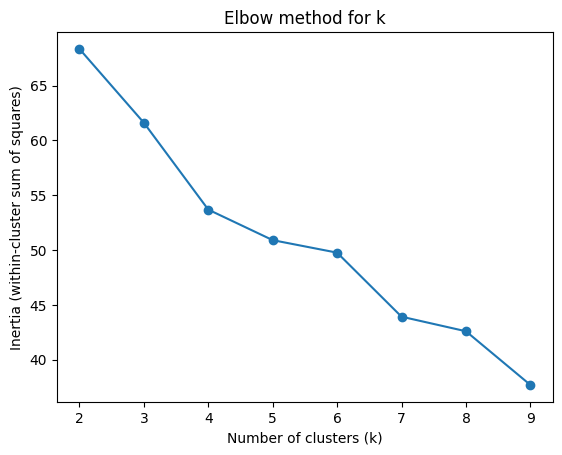

In [ ]:
inertias = []
candidate_ks = range(2, 10)

for k in candidate_ks:
    km = KMeans(n_clusters=k, random_state=0, n_init="auto")
    km.fit(X)
    inertias.append(km.inertia_)


plt.figure()
plt.plot(candidate_ks, inertias, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (within-cluster sum of squares)")
plt.title("Elbow method for k")
plt.show()


We tried different numbers of clusters from 2 to 9, and looked at the k-means inertia. The curve bends around k = 4: the inertia drops a lot between 2 and 4, but after 4 it only gets a little better. So we chose 4 clusters as a good balance between keeping the model simple and having reasonably tight clusters.

## 3.3 Cluster texts using k-means

In [ ]:
# k-means clustering
n_clusters = 4
km = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto")
df["topic"] = km.fit_predict(X)

## 3.4 Show top keywords and example texts for each topic

In [ ]:
feature_names = tfidf.get_feature_names_out()
centers = km.cluster_centers_

for topic_id in range(n_clusters):
    print(f"\n=== Topic {topic_id} ===")
    top_idx = np.argsort(centers[topic_id])[::-1][:10]
    print("Top keywords:", ", ".join(feature_names[i] for i in top_idx))

    print("Example texts:")
    examples = df[df["topic"] == topic_id]["text"].head(3)
    for ex in examples:
        print("-", ex)


=== Topic 0 ===
Top keywords: rs185031519, glis1, biomarker, fluid, csf, ab1, 42, onset, age, tau181p
Example texts:
- rs185031519 GLIS1 CSF Ab1-42 Fluid biomarker
- rs185031519 GLIS1 CSF Ab1-42 Fluid biomarker
- rs185031519 GLIS1 AD Progression (based on CDR Score) Cognitive

=== Topic 1 ===
Top keywords: adrd, pd, tceanc2, expression, performance, episodic, memory, cognitive, zbtb8os, tmem59
Example texts:
- rs12074379 ESPN ESPN (ILMN_1806710) expression Expression
- rs2379135 DISP3 MRI Imaging
- rs1763601 HSPB7 CLCNKA expression in Cerebellar Expression

=== Topic 2 ===
Top keywords: ad, load, agbl4, efcab14, rs7519866, rs7527934, kazn, rere, rs112053331, rs16824888
Example texts:
- rs12074379 ESPN AD AD
- rs112053331 RERE AD AD
- rs112053331 RERE AD AD

=== Topic 3 ===
Top keywords: uptake, rs7551288, pib, dhcr24, imaging, gyrus, frontal, left, right, ba9
Example texts:
- rs7551288 DHCR24 PiB uptake in Left medial frontal gyrus (BA9) Imaging
- rs7551288 DHCR24 PiB uptake in Left m

## 3.5 Bonus Feature: Mini "curator view"

In [ ]:
def curator_view(gene_filter="", variant_filter="", topic_filter="All"):
    sub = entities_df.copy()

    if gene_filter:
        sub = sub[sub["gene"].str.contains(gene_filter, case=False, na=False)]
    if variant_filter:
        sub = sub[sub["variant"].str.contains(variant_filter, na=False)]

    if topic_filter != "All":
        t = int(topic_filter)
        sub = sub[df["topic"] == t]

    display(sub.head(20))

interact(
    curator_view,
    gene_filter=Text(description="Gene"),
    variant_filter=Text(description="Variant"),
    topic_filter=Dropdown(
        options=["All"] + [str(t) for t in sorted(df["topic"].unique())],
        description="Topic"
    )
)

interactive(children=(Text(value='', description='Gene'), Text(value='', description='Variant'), Dropdown(desc…

<function __main__.curator_view(gene_filter='', variant_filter='', topic_filter='All')>

## 3.6 Visualization

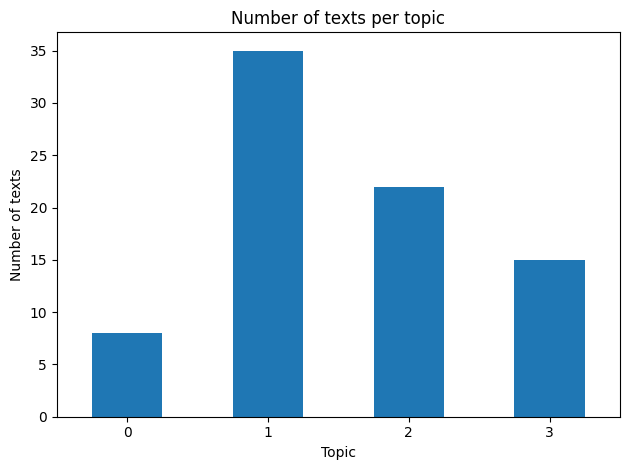

In [ ]:
topic_counts = df["topic"].value_counts().sort_index()

plt.figure()
topic_counts.plot(kind="bar")
plt.xlabel("Topic")
plt.ylabel("Number of texts")
plt.title("Number of texts per topic")
plt.xticks(rotation=360)
plt.tight_layout()
plt.show()

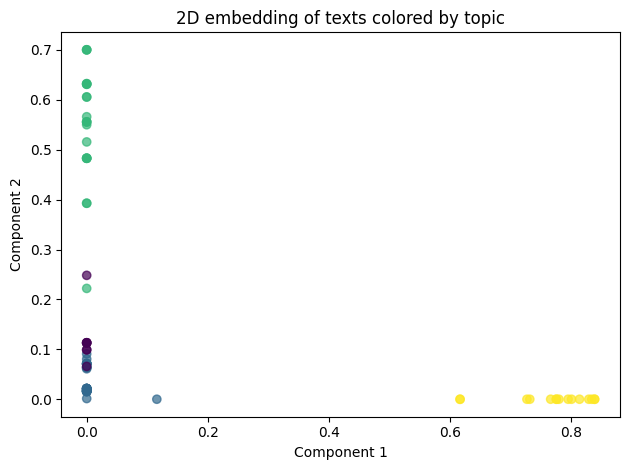

In [ ]:
svd = TruncatedSVD(n_components=2, random_state=0)
X_2d = svd.fit_transform(X)

plt.figure()
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=df["topic"], alpha=0.7)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("2D embedding of texts colored by topic")
plt.tight_layout()
plt.show()

We reduced the TF-IDF document vectors to two dimensions and plotted them colored by k-means topic. One topic appears clearly separated along Component 1, while the remaining topics overlap more, so the groups are only partly separated in this 2D view. Because we are squeezing many original dimensions down to just two, clusters that are well separated in the full space can still overlap in the 2D plot. So overlap in the picture does not necessarily mean the topics are truly mixed, just that they are not cleanly split along these two main directions.

## 3.7 Bonus Feature: Error Analysis

In [ ]:
error_sample = df[["text", "variants", "genes", "disease_phrases"]].sample(
    40, random_state=0
)
error_sample.to_csv("error_analysis_sample.csv", index=False)
error_sample


,text,variants,genes,disease_phrases
50,rs35109297 TMEM59 PD ADRD,[rs35109297],"[TMEM59, ADRD]",[]
27,rs61779841 TRIT1 High-density lipoprotein (HDL...,[rs61779841],"[TRIT1, HDL, ADRD]",[]
30,rs7519866 EFCAB14 LOAD AD,[rs7519866],"[EFCAB14, LOAD]",[]
77,rs7551288 DHCR24 PiB uptake in Left precentral...,[rs7551288],"[DHCR24, BA9]",[]
45,rs185031519 GLIS1 CSF Ab1-42 Fluid biomarker,[rs185031519],"[GLIS1, CSF]",[]
71,rs7551288 DHCR24 PiB uptake in Right precentra...,[rs7551288],"[DHCR24, BA44]",[]
66,rs7551288 DHCR24 PiB uptake in Left middle fro...,[rs7551288],"[DHCR24, BA6]",[]
68,rs7551288 DHCR24 PiB uptake in Left inferior f...,[rs7551288],"[DHCR24, BA47]",[]
48,rs6696554 LDLRAD1 PD ADRD,[rs6696554],"[LDLRAD1, ADRD]",[]
69,rs7551288 DHCR24 PiB uptake in Right middle fr...,[rs7551288],"[DHCR24, BA9]",[]


**False Positives**

1. Sometimes the genes list has more than one token, but only one of them matches the nearest_gene_symb column. Any extra token that is not equal to nearest_gene_symb is probably not a real gene and is a false positive.

2. Many short codes like AD, PD, ADRD, LOAD, HDL, CSF behave like disease/trait labels in the dataset (they appear in Phenotype / Phenotype-derived), but our code sometimes puts them into genes. These are likely false positive genes.

3. Codes like BA9, BA44, BA6, BA47 never appear as nearest_gene_symb, but show up inside longer text phrases. When our regex tags them as genes, they are probably false positives too.

**False Negatives**

1. If Phenotype or Phenotype-derived is filled in, but disease_phrases is an empty list, it means our pattern failed to catch any disease term there (false negative).

2. Phrases like “High-density lipoprotein (HDL …)” contain important trait information, but our disease_phrases pattern often misses them because they use hyphens and lowercase words. These are disease/trait terms that should be captured but are not, so they are false negatives.